In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import pywt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf
from keras.optimizers import SGD, Adam
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError
from sklearn.metrics import mean_absolute_error as mae

In [3]:
#doc dataset
df = pd.read_csv("ALL.csv")
df.head()
print(df.isnull().sum())
#xử lí giá trị âm
colum_press = ['BO1016_Pressure(m)', 'BO1017_Pressure(m)', 'BO1021_Pressure', 'BO1022_Pressure(m)', 'BO1029_Pressure(m)', 'NB1019_Pressure', 'TD1029_Pressure', 'TD1043_Press(m)']
df[colum_press] = df[colum_press].apply(lambda x:x+5)
df.columns

Date_time             0
BO1013_FLOW1          0
BO1016_Pressure(m)    0
BO1017_Pressure(m)    0
BO1021_FLOW1)         0
BO1021_Pressure       0
BO1022_flow1          0
BO1022_Pressure(m)    0
BO1017_FLOW1          0
BO1029_FLOW1          0
BO1029_Pressure(m)    0
NB1013_FLOW1          0
NB1017_FLOW1          0
NB1017_Pressure       0
NB1019_FLOW1          0
NB1019_Pressure       0
NB1020_FLOW1          0
NB1021_FLOW1          0
NB1022_FLOW1          0
TD1029_flow1          0
TD1029_Pressure       0
TD1043_FLOW1          0
TD1043_Press(m)       0
NMNBOOTM1_FLOW1       0
BOO_TM2_Pressure      0
dtype: int64


Index(['Date_time', 'BO1013_FLOW1', 'BO1016_Pressure(m)', 'BO1017_Pressure(m)',
       'BO1021_FLOW1)', 'BO1021_Pressure', 'BO1022_flow1',
       'BO1022_Pressure(m)', 'BO1017_FLOW1', 'BO1029_FLOW1',
       'BO1029_Pressure(m)', 'NB1013_FLOW1', 'NB1017_FLOW1', 'NB1017_Pressure',
       'NB1019_FLOW1', 'NB1019_Pressure', 'NB1020_FLOW1', 'NB1021_FLOW1',
       'NB1022_FLOW1', 'TD1029_flow1', 'TD1029_Pressure', 'TD1043_FLOW1',
       'TD1043_Press(m)', 'NMNBOOTM1_FLOW1', 'BOO_TM2_Pressure'],
      dtype='object')

In [4]:
# dịch áp suất
  # Shift the control column (last column)
df['BOO_TM2_Pressure_Shifted'] = df['BOO_TM2_Pressure'].shift(1)

  # Drop the first row since it will have NaN in the shifted control column
df.dropna(inplace=True)
#tách tập trạng thái và tập điều khiển--------------
df.set_index("Date_time", inplace=True) #set index
control = df["BOO_TM2_Pressure"]
# state = df
state_ = df.drop([ "BOO_TM2_Pressure", 'BOO_TM2_Pressure_Shifted'], axis = 1)
features = df.drop([ "BOO_TM2_Pressure", 'BOO_TM2_Pressure_Shifted'], axis = 1).columns
scaler =MMS() #scale data
state_scaler = scaler.fit_transform(state_[features])
state = pd.DataFrame(columns=features, data=state_scaler, index = df["BOO_TM2_Pressure"].index)
control_scaler = scaler.fit_transform(control.values.reshape(-1, 1)) 
control = pd.DataFrame(columns=["BOO_TM2_Pressure"], data=control_scaler, index = df.index)
# check
print(state.head())
print(control.head())
# tạo biến thử
dense_act = ['ReLU', 'elu', 'tanh', 'sigmoid', 'selu'] 
recur_act = ['ReLU', 'elu', 'tanh', 'sigmoid', 'selu']
epoch = 100
# epoch = [100, 256, 500]
learning_r = 0.001
# learning_r = [0.0005, 0.001, 0.002] 
ls = 'mae'
# ls = ['mae', 'mse']
'''opt1 = SGD()
opt2 = Adam()'''
print('yes')
kind = []
sc = []

                BO1013_FLOW1  BO1016_Pressure(m)  BO1017_Pressure(m)  \
Date_time                                                              
9/15/2023 0:15      0.450752            0.622623            0.389156   
9/15/2023 0:30      0.439808            0.627547            0.402763   
9/15/2023 0:45      0.430233            0.632392            0.413858   
9/15/2023 1:00      0.416211            0.637787            0.426732   
9/15/2023 1:15      0.403557            0.642764            0.437879   

                BO1021_FLOW1)  BO1021_Pressure  BO1022_flow1  \
Date_time                                                      
9/15/2023 0:15       0.366363         0.430262      0.228169   
9/15/2023 0:30       0.370728         0.431107      0.230986   
9/15/2023 0:45       0.368668         0.450549      0.239789   
9/15/2023 1:00       0.342378         0.417582      0.247183   
9/15/2023 1:15       0.333304         0.437025      0.193310   

                BO1022_Pressure(m)  BO1017_FLO

In [5]:
X = []
Y = []
# Loop qua các hàng của dataframe để lấy các cửa sổ thời gian t-5 đến t và giá trị tại t+1 cho Y
for i in range(288, len(df) - 1):
    X.append(state.iloc[i-288:i].values)  # Lấy cửa sổ thời gian t-5 đến < t
    Y.append(control.iloc[i-1])  # Lấy giá trị <t của cột cuối cùng

X = np.array(X)
Y = np.array(Y)
X[0], Y[0]

(array([[0.45075239, 0.62262323, 0.38915637, ..., 0.3015873 , 0.52747253,
         0.54611657],
        [0.43980848, 0.62754701, 0.40276324, ..., 0.28258145, 0.52747253,
         0.53398064],
        [0.43023256, 0.63239223, 0.41385807, ..., 0.28341688, 0.52747253,
         0.52427191],
        ...,
        [0.5369357 , 0.66245875, 0.4432175 , ..., 0.36319967, 0.59340659,
         0.62135922],
        [0.50444596, 0.65046357, 0.42992464, ..., 0.35066834, 0.59340659,
         0.61407767],
        [0.46067031, 0.61968991, 0.38025958, ..., 0.29824561, 0.52747253,
         0.5873787 ]]),
 array([0.13815261]))

In [6]:
z = []
for i in range(288, len(df) - 1):
    z.append(control.iloc[i-288:i-1]) 
z = np.array(z)

In [7]:
X.shape, Y.shape, z.shape

((10174, 288, 23), (10174, 1), (10174, 287, 1))

In [15]:
X_state_tr, X_state_te, y_state_tr, y_state_te = train_test_split(X, Y, test_size = 0.25, random_state = 25)
X_state_tr.shape , y_state_tr.shape

((7630, 288, 23), (7630, 1))

In [8]:
opt1 = Adam(learning_rate= 0.001)
model1 = Sequential([
        tf.keras.layers.LSTM(64, recurrent_activation = 'tanh', input_shape = [288, 23]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation = 'elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation = 'elu'),
        tf.keras.layers.Dense(8, activation = 'elu'),
        tf.keras.layers.Dense(1)
                         ])
model1.compile(optimizer = opt1, loss = ls, )
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                22528     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9

In [35]:
apply1 = model1.fit(X_state_tr, y_state_tr, batch_size = 1024, epochs = 500, validation_split = 0.2)

Epoch 1/500
6/6 [==============================] - 52s 8s/step - loss: 0.1729 - val_loss: 0.1283
Epoch 2/500
6/6 [==============================] - 10s 2s/step - loss: 0.1227 - val_loss: 0.1126
Epoch 3/500
6/6 [==============================] - 11s 2s/step - loss: 0.1062 - val_loss: 0.0875
Epoch 4/500
6/6 [==============================] - 11s 2s/step - loss: 0.0945 - val_loss: 0.0816
Epoch 5/500
6/6 [==============================] - 10s 2s/step - loss: 0.0871 - val_loss: 0.0757
Epoch 6/500
6/6 [==============================] - 10s 2s/step - loss: 0.0808 - val_loss: 0.0700
Epoch 7/500
6/6 [==============================] - 11s 2s/step - loss: 0.0752 - val_loss: 0.0665
Epoch 8/500
6/6 [==============================] - 11s 2s/step - loss: 0.0719 - val_loss: 0.0642
Epoch 9/500
6/6 [==============================] - 10s 2s/step - loss: 0.0693 - val_loss: 0.0628
Epoch 10/500
6/6 [==============================] - 11s 2s/step - loss: 0.0678 - val_loss: 0.0608
Epoch 11/500
6/6 [===========

6/6 [==============================] - 15s 2s/step - loss: 0.0353 - val_loss: 0.0348
Epoch 168/500
6/6 [==============================] - 15s 3s/step - loss: 0.0357 - val_loss: 0.0341
Epoch 169/500
6/6 [==============================] - 14s 3s/step - loss: 0.0352 - val_loss: 0.0348
Epoch 170/500
6/6 [==============================] - 16s 3s/step - loss: 0.0351 - val_loss: 0.0336
Epoch 171/500
6/6 [==============================] - 14s 2s/step - loss: 0.0350 - val_loss: 0.0348
Epoch 172/500
6/6 [==============================] - 14s 2s/step - loss: 0.0353 - val_loss: 0.0364
Epoch 173/500
6/6 [==============================] - 13s 2s/step - loss: 0.0368 - val_loss: 0.0361
Epoch 174/500
6/6 [==============================] - 15s 2s/step - loss: 0.0365 - val_loss: 0.0351
Epoch 175/500
6/6 [==============================] - 13s 2s/step - loss: 0.0347 - val_loss: 0.0338
Epoch 176/500
6/6 [==============================] - 13s 2s/step - loss: 0.0348 - val_loss: 0.0335
Epoch 177/500
6/6 [=====

Epoch 250/500
6/6 [==============================] - 17s 3s/step - loss: 0.0307 - val_loss: 0.0298
Epoch 251/500
6/6 [==============================] - 16s 3s/step - loss: 0.0305 - val_loss: 0.0303
Epoch 252/500
6/6 [==============================] - 16s 3s/step - loss: 0.0311 - val_loss: 0.0323
Epoch 253/500
6/6 [==============================] - 13s 2s/step - loss: 0.0304 - val_loss: 0.0322
Epoch 254/500
6/6 [==============================] - 12s 2s/step - loss: 0.0311 - val_loss: 0.0295
Epoch 255/500
6/6 [==============================] - 12s 2s/step - loss: 0.0306 - val_loss: 0.0308
Epoch 256/500
6/6 [==============================] - 12s 2s/step - loss: 0.0312 - val_loss: 0.0302
Epoch 257/500
6/6 [==============================] - 13s 2s/step - loss: 0.0310 - val_loss: 0.0316
Epoch 258/500
6/6 [==============================] - 13s 2s/step - loss: 0.0307 - val_loss: 0.0304
Epoch 259/500
6/6 [==============================] - 12s 2s/step - loss: 0.0312 - val_loss: 0.0303
Epoch 260/

Epoch 415/500
6/6 [==============================] - 13s 2s/step - loss: 0.0231 - val_loss: 0.0241
Epoch 416/500
6/6 [==============================] - 13s 2s/step - loss: 0.0233 - val_loss: 0.0235
Epoch 417/500
6/6 [==============================] - 13s 2s/step - loss: 0.0237 - val_loss: 0.0237
Epoch 418/500
6/6 [==============================] - 14s 2s/step - loss: 0.0239 - val_loss: 0.0248
Epoch 419/500
6/6 [==============================] - 15s 3s/step - loss: 0.0235 - val_loss: 0.0241
Epoch 420/500
6/6 [==============================] - 14s 2s/step - loss: 0.0232 - val_loss: 0.0237
Epoch 421/500
6/6 [==============================] - 13s 2s/step - loss: 0.0230 - val_loss: 0.0232
Epoch 422/500
6/6 [==============================] - 12s 2s/step - loss: 0.0228 - val_loss: 0.0238
Epoch 423/500
6/6 [==============================] - 13s 2s/step - loss: 0.0232 - val_loss: 0.0236
Epoch 424/500
6/6 [==============================] - 12s 2s/step - loss: 0.0232 - val_loss: 0.0229
Epoch 425/

In [38]:
model.save('model_rep1.h5')

C:\Users\ainzo\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
def Scale(x):
    scaler = MMS() 
    data = scaler.fit_transform(x)
    return data, scaler
def InverseScale(data, scaler):
    predictions = scaler.inverse_transform(data.reshape(-1, 1)).flatten()
    return predictions
def Create_data(dataX, m):
    if(m == 'X'):
        negative_press = dataX.drop('Date_time', axis =1).min()[dataX.drop('Date_time', axis =1).min() < 0].index.tolist()
        dataX[negative_press] = dataX[negative_press].apply(lambda x:x+5)
#     ------------------------------------------
        dataX.set_index("Date_time", inplace=True) #set index
#     ------------------------------------------
        features = dataX.columns
        control = dataX["BOO_TM2_Pressure"]
        dataX_scaler, scaler = Scale(dataX[features])
        control, scaler = Scale(control.values.reshape(-1, 1))
        dataX = pd.DataFrame(columns=features, data=dataX_scaler, index = dataX.index)
        X = []
        X.append(dataX.values)
        X = np.array(X)
#         window = X.shape[1]
#         feat = X.shape[2]
#         X = X.reshape(window, feat)
        return X, scaler
from tensorflow.keras.models import load_model
loaded_model = load_model('model_rep1.h5')

In [16]:
y = loaded_model.predict(X_state_te).flatten()
InverseScale(y, scaler)
y_state_tr

80/80 [==============================] - 5s 53ms/step


array([[0.17590361],
       [0.27630522],
       [0.22008032],
       ...,
       [0.64738956],
       [0.15100402],
       [0.69156627]])

80/80 [==============================] - 3s 40ms/step


(      Predictions  Actuals
 0       12.945598   12.929
 1       12.639218   12.616
 2       13.334943   13.359
 3       13.175740   13.234
 4       13.272714   13.187
 ...           ...      ...
 2539    13.050053   12.905
 2540    13.003996   12.976
 2541    12.994985   13.015
 2542    13.250055   13.453
 2543    13.123783   13.109
 
 [2544 rows x 2 columns],
 0.055039179322104684)

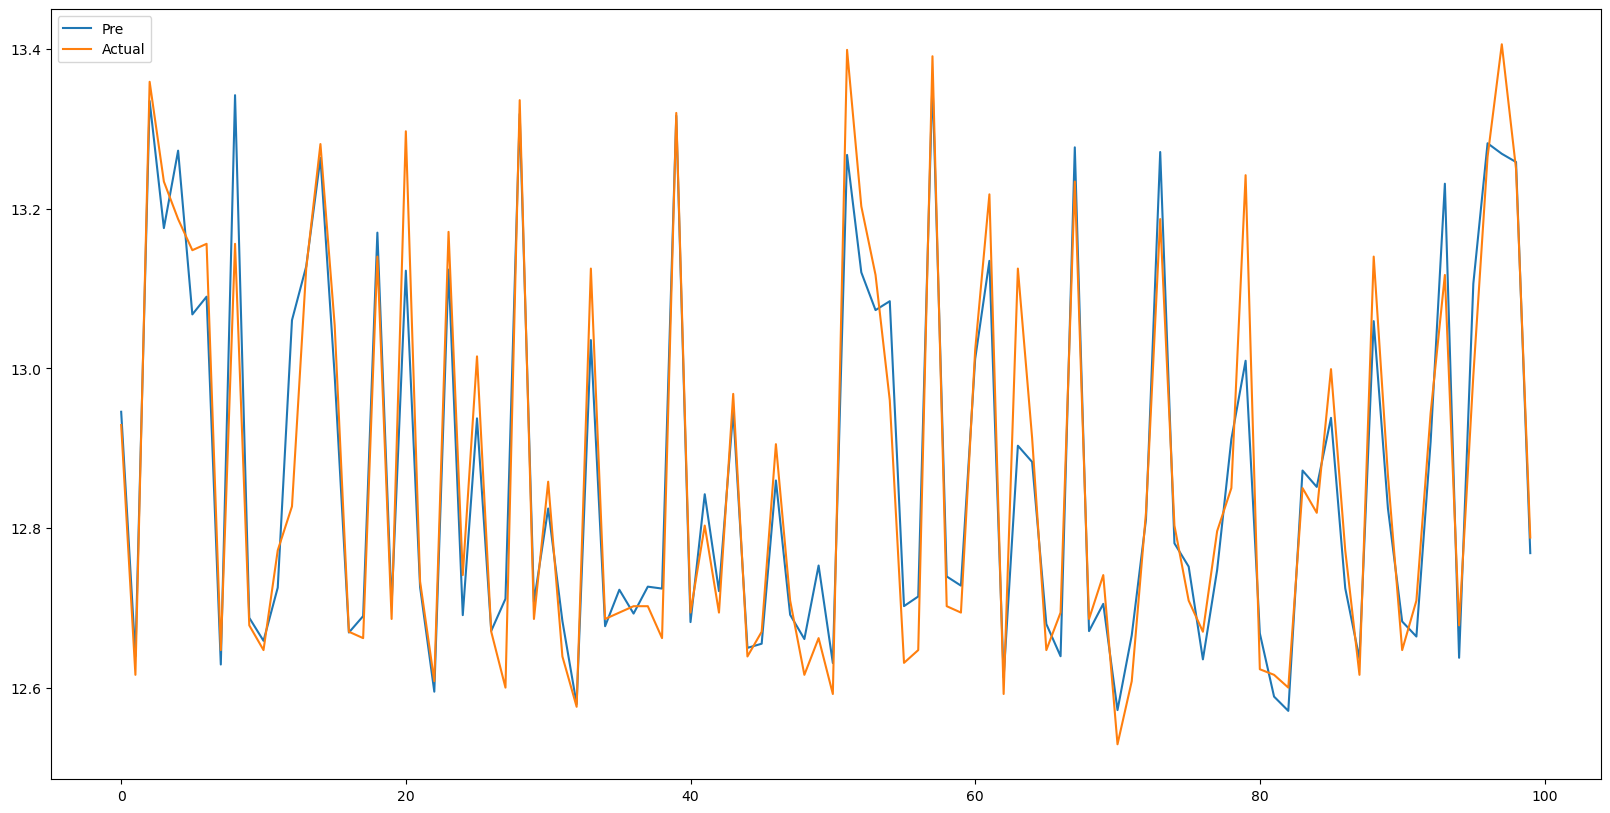

In [17]:
def plot_predictions1(loaded_model, X, y_scaled, start=0, end=100):
    y_pred_scaled = loaded_model.predict(X).flatten()
    predictions = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y = scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.figure(figsize=(20,10))
    plt.plot(df['Predictions'][start:end], label = 'Pre')
    plt.plot(df['Actuals'][start:end], label = 'Actual')
    plt.legend()
    return df, mae(y, predictions)
plot_predictions1(loaded_model, X_state_te, y_state_te)

In [18]:
z_state_tr, z_state_te, y_state_tr, y_state_te = train_test_split(z, Y, test_size = 0.25, random_state = 25)
z_state_tr.shape , y_state_tr.shape

((7630, 287, 1), (7630, 1))

In [19]:
opt1 = Adam(learning_rate= 0.001)
model2 = Sequential([
        tf.keras.layers.LSTM(64, recurrent_activation = 'tanh', input_shape = [287, 1]),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation = 'elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation = 'elu'),
        tf.keras.layers.Dense(8, activation = 'elu'),
        tf.keras.layers.Dense(1)
                         ])
model2.compile(optimizer = opt1, loss = ls, )
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
apply2 = model2.fit(z_state_tr, y_state_tr, batch_size = 1024, epochs = 500, validation_split = 0.2)

Epoch 1/500
6/6 [==============================] - 18s 2s/step - loss: 0.2650 - val_loss: 0.2091
Epoch 2/500
6/6 [==============================] - 13s 2s/step - loss: 0.1703 - val_loss: 0.1528
Epoch 3/500
2/6 [=========>....................] - ETA: 8s - loss: 0.1481

In [ ]:
model.save('model_rep1.h5')